### Tianyu Zhang tz1280@nyu.edu Assignment 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import cv2
from scipy.linalg import null_space
import scipy.io as sio
from mpl_toolkits.mplot3d import *
import matplotlib.pyplot as plt

## Problem 1

First run the SIFT detector over both images to produce a set
of regions, characterized by a 128d descriptor vector. Display these regions
on each picture to ensure that a satsifactory number of them have been
extracted. Please include the images in your report.

In [2]:
images = ['book.pgm', 'scene.pgm']
def SIFT(image):
    img = cv2.imread(image)
    img_raw = img
    sift = cv2.xfeatures2d.SIFT_create()
    kps, descs = sift.detectAndCompute(img, None)
    img_disp=cv2.drawKeypoints(img,kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_raw, img_disp, kps, descs

img_raw1, img_disp1, kp1, des1 = SIFT(images[0])
img_raw2, img_disp2, kp2, des2 = SIFT(images[1])
info1 = img_disp1, kp1, des1
info2 = img_disp2, kp2, des2

When we are note using Jupyter, we can plot the image by cv2 package (see below), but using matplotlib is more convenient in Jupyter Notebook
```python
cv2.startWindowThread()
cv2.imshow('image',img1)
cv2.waitKey(5000)
# waiting for 5 seconds for screenshot
cv2.destroyWindow('image')

cv2.startWindowThread()
cv2.imshow('image',img2)
cv2.waitKey(5000)
# waiting for 5 seconds for screenshot
cv2.destroyWindow('image')
```

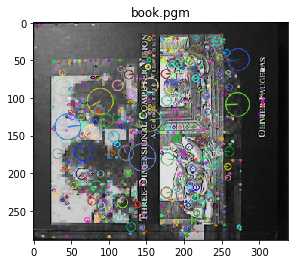

In [3]:
plt.imshow(img_disp1)
plt.title('book.pgm')
plt.show()

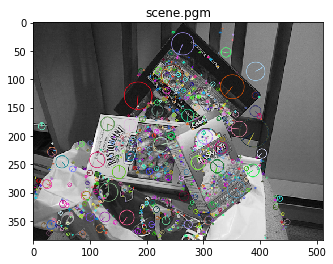

In [4]:
plt.imshow(img_disp2)
plt.title('scene.pgm')
plt.show()

Obtain a set of putative matches T and test the functioning of RANSAC, plot out the two images side-by-side with lines showing the potential matches

In [5]:
def Matcher(info1, info2, threshold = 0.9, Nfilter_ = -1, flags = 0):
    
    img1, kp1, des1 = info1
    img2, kp2, des2 = info2
    
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(queryDescriptors=des1,trainDescriptors=des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append(m)
    filter_ = sorted(good, key = lambda x: x.distance)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,filter_[:Nfilter_],None,flags=flags)
    print("# matches shown in the following picture: ",len(filter_[:Nfilter_]))
    plt.figure(figsize=(15,20))
    plt.imshow(img3)
    plt.show()
    return good, filter_[:Nfilter_], img3

This is the result for all the matches

# matches shown in the following picture:  244


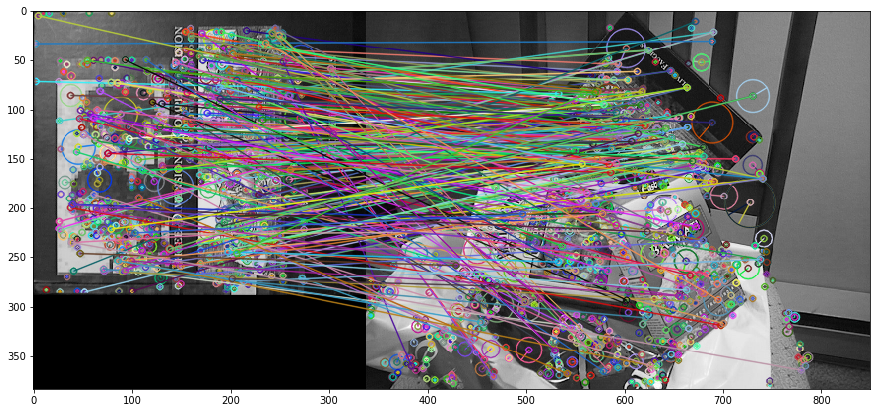

In [6]:
good, _, _ = Matcher(info1, info2, threshold = 0.9, Nfilter_ = None)

# matches shown in the following picture:  10


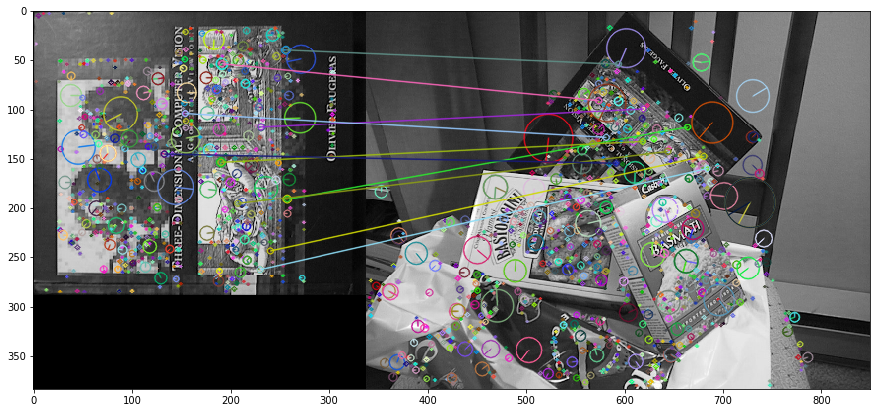

In [7]:
good, _, _ = Matcher(info1, info2, threshold = 0.9, Nfilter_ = 10, flags=2)

RANSAC Part to improve the result from the SIFT:


Repeat N times (where N is ∼100):


• Pick P matches at random from the total set of matches T. Since we
are solving for an affine transformation which has 6 degrees of freedom,
we only need to select P=3 matches.


• Construct a matrix A and vector b using the 3 pairs of points as described in lecture 6.


• Solve for the unknown transformation parameters q. 


• Using the transformation parameters, transform the locations of all T
points in image 1. If the transformation is correct, they should lie close
to their pairs in image 2.


• Count the number of inliers, inliers being defined as the number of
transformed points from image 1 that lie within a radius of 10 pixels
of their pair in image 2.


• If this count exceeds the best total so far, save the transformation
parameters and the set of inliers.

• End repeat.

The refit process:

• Perform a final refit using the set of inliers belonging to the best transformation. This refit should use all inliers, not just 3 points.

In [8]:
good = np.array(good)

In [9]:
def aug(arr):
    '''
    This function is for augment the array that will be used in this probelm
    '''
    arr0 = arr
    aug = np.ones((arr.shape[0],arr0.shape[1],1))
    return np.append(arr0, aug, axis=2)

def getAugQorT(good, kp1, kp2, isQuery = True):
    """
    This function is to get the agument version of scriptors and descriptors
    """
    if isQuery:
        tmp = np.array([kp1[m.queryIdx].pt for m in good])
    else:
        tmp = np.array([kp2[m.trainIdx].pt for m in good])
    return aug(tmp.reshape(-1,1,2))
def getRANSACsource(good, kp1, kp2):
    """
    This function is to integrate the data that the RANSAC needed 
    """
    augSrcPts = getAugQorT(good, kp1, kp2, True)
    augDstPts = getAugQorT(good, kp1, kp2, False)
    Rsource = []
    for i in range(len(augSrcPts)):
        Rsource.append([augSrcPts[i], augDstPts[i]])
    return np.array(Rsource)

In [10]:
Rsource = getRANSACsource(good, kp1, kp2)
Rsource = list(Rsource)
def runRANSAC(img1, img2, data):
    """
    This function runs the RANSAC and the refit process
    """
    # phase one
    bestcount = 0
    for i in range(100): # repeat N times 
        inL = [] # inliers
        # pick P matches without replacement
        sample = random.sample(data, 3)
        coefMat = np.zeros((1,6))
        tarVec = np.zeros((1,1))
        # build up the linear system to solve the unknown transformation parameters q
        for i in range(3): 
            temp = np.append(sample[i][0], np.zeros((1,3)), axis=1)
            temp1 = np.append(np.zeros((1,3)), sample[i][0], axis=1)
            coefMat = np.append(coefMat,temp, axis=0)
            coefMat = np.append(coefMat,temp1, axis=0)
            tarVec = np.append(tarVec, sample[i][1].reshape((3,1))[:-1], axis =0)
        coefMat = coefMat[1:, :]
        tarVec = tarVec[1:, :]
        try:
            # the coefficient matrix is not gauranteed to be full rank, thus, the solution will not always exists
            sol = np.linalg.solve(coefMat, tarVec)
        except:
            sol = None
            continue
        count = 0
        # judge the inliers
        for j in range(len(data)):
            a = sol.reshape((2,3)).dot(data[j][0].T).reshape((1,2))
            b = np.delete(data[j][1], 2, axis=1).reshape((1,2))
            if np.linalg.norm(a-b) < 10:
                count += 1
                inL.append(data[j])
        # get the best models and inliers
        if count > bestcount:
            bestcount = count
            bestmodel = sol
            bestinliners = inL
    bestmodel = bestmodel.reshape((2,3))
    # phase 2
    refit_model = np.zeros((6,1))
    count_singularity = 0
    for i in range(len(bestinliners)-2):
        refit_list = [bestinliners[i], bestinliners[i+1], bestinliners[i+2]]
        # get the refit model by the refit list by solving linear system
        coefMat = np.zeros((1,6)) # coefficient Matrix
        tarVec = np.zeros((1,1)) # target Matrix
        for i in range(3):
            temp = np.append(refit_list[i][0], np.zeros((1,3)), axis=1)
            temp1 = np.append(np.zeros((1,3)), refit_list[i][0], axis=1)
            coefMat = np.append(coefMat,temp, axis=0)
            coefMat = np.append(coefMat,temp1, axis=0)
            tarVec = np.append(tarVec, refit_list[i][1].reshape((3,1))[:-1], axis =0)
        coefMat = coefMat[1:, :]
        tarVec = tarVec[1:, :]
        try:
            # the coefficient matrix is not gauranteed to be full rank, thus, the solution will not always exists
            sol = np.linalg.solve(coefMat, tarVec)
        except:
            sol = None
            continue
        sol = np.linalg.solve(coefMat, tarVec)
        refit_model += sol
    refit_model = refit_model / (len(bestinliners) - count_singularity)
    refit_model = refit_model.reshape((2, 3))
    return bestcount,refit_model,bestmodel

In [11]:
result = runRANSAC(img_raw1, img_raw2, Rsource)
print('Best number of inliers:', result[0])

Best number of inliers: 114


Homography matrix H

In [12]:
print("H_Matrix:",result[1])

H_Matrix: [[ -0.42677653   0.34096237 296.52428582]
 [ -1.03876106   0.31127105 298.76436869]]


Image transformation


• Finally, transform image 1 using this final set of transformation parameters, q. Use the cv2.warpAffine from the OpenCV-Python environment. Display this image and find that the pose of the book in the scene should correspond to its pose in image 2.

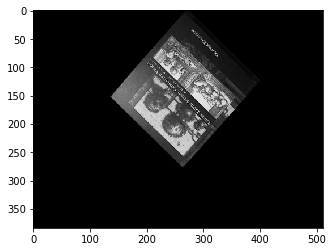

In [13]:
pose = cv2.warpAffine(img_raw1, result[2], (img_raw2.shape[1], img_raw2.shape[0]))
plt.imshow(pose)
plt.show()

## Problem 2

Loading the data

In [14]:
world = np.loadtxt("world.txt")
image = np.loadtxt("image.txt")
len_ = len(world)

def agument(input_arr):
    input_arr = np.array(input_arr)
    Shape_ = input_arr.shape
    aug_arr = np.ones((1,Shape_[-1]))
    return np.append(input_arr, aug_arr, axis=0)

aguWorld = agument(world)
aguImg = agument(image)

zero_Vec = np.zeros((4, 1))
A = np.zeros((1,12))

Calculating the P matrix by a series of linear equations

$$\begin{bmatrix}
    O^T & -w_i\mathbf{X}_{i}^T & y_i\mathbf{X}_{i}^T \\
    w_i\mathbf{X}_{i}^T & O^T & -x_i\mathbf{X}_{i}^T \\
    -y_i\mathbf{X}_{i}^T & x_i\mathbf{X}_{i}^T & O^T
\end{bmatrix}
\quad
\begin{pmatrix}
    P^1 \\
    P^2 \\
    P^3
\end{pmatrix}
= 0$$

for each correspondence $\mathbf{x}_i \leftrightarrow \mathbf{X}_i$, where $\mathbf{x}_i = (x_i, y_i, w_i)^T$, $w_i$ being the homogeneous coordinate, and $P^j$ is the $j^{th}$ row of $P$. But since the 3rd row is a linear combination of the first two, we need only consider the first two rows for each correspondence $i$. Thus, you should form a 20
by 12 matrix $A$, each of the 10 correspondences contributing two rows. This yields $Ap = 0$, $p$ being the vector containing the entries of matrix $P$.


To solve for $p$, we need to impose an extra constraint to avoid the trivial solution $p = 0$. One simple one is to use ${\left\lVert p \right\rVert}_2 = 1$. This constraint is implicitly imposed when we compute the SVD of $A$. The value of $p$ that minimizes $Ap$ subject to ${\left\lVert p \right\rVert}_2 = 1$ is given by the eigenvector corresponding to the smallest singular value of A. To find this, compute the SVD of $A$, picking this eigenvector and reshaping it into a 3 by 4 matrix $P$.

In [15]:
for i in range(10):
    xi_ = aguImg[:, i].reshape(3,1)
    Xi = aguWorld[:, i].reshape(4,1)
    part1 = np.concatenate((zero_Vec.T, -1*xi_[2] * Xi.T, xi_[1] * Xi.T), axis=1)
    part2 = np.concatenate((-1*xi_[2] *  Xi.T, zero_Vec.T, xi_[0] * Xi.T), axis=1)
    A = np.append(A, part1, axis=0)
    A = np.append(A, part2, axis=0)

# remove the first zeros
A = A[1:,:]

# Estimation of the P matrix
P = np.linalg.svd(A)[2][-1, :].reshape((3, 4))
print ("Estimation of Camera Matrix P:")
print (P)

Estimation of Camera Matrix P:
[[ 1.27000127e-01  2.54000254e-01  3.81000381e-01  5.08000508e-01]
 [ 5.08000508e-01  3.81000381e-01  2.54000254e-01  1.27000127e-01]
 [ 1.27000127e-01 -4.16333634e-17  1.27000127e-01 -5.55111512e-17]]


Two ways to estimation the center C:

Method 1:

Now we have P, we can compute the world coordinates of the projection
center of the camera C. Note that PC = 0, thus C lies in the null
space of P, which can again be found with an SVD (the Matlab command
is svd). Compute the SVD of P and pick the vector corresponding to this
null-space. Finally, convert it back to inhomogeneous coordinates and to
yield the (X,Y,Z) coordinates. Your report should contain the matrix P and
the value of C.

In [16]:
# Method1 : Estimation of the Center
C = np.linalg.svd(P)[2][-1, :]
C = (C/C[-1])[:-1]
print ("Estimation of Projection Center C:")
print (C)

Estimation of Projection Center C:
[ 1. -1. -1.]


In the alternative route, we decompose P into it’s constituent matrices. Recall from the lectures that P = K[R|t]. However, also, $t = −R\hat{C}$, $\hat{C}$ being the inhomogeneous form of C. Since K is upper triangular, use a RQdecomposition to factor $KR$ into the intrinsic parameters K and a rotation matrix
R. Then solve for $\hat{C}$. Check that your answer agrees with the solution from
the first method.

In [17]:
# Method2 : Estimation of the Center
R = -1*np.linalg.qr(P.T)[0][:-1,:].T
RChat = np.linalg.qr(P.T)[0][-1,:].T
C = np.linalg.solve(R, RChat)
print("C_hat estimation (QR Decomposition):", C)

C_hat estimation (QR Decomposition): [ 1. -1. -1.]


## Problem 3

Loading the data

In [18]:
sfm = sio.loadmat('sfm_points.mat')
center = np.zeros((2,1))
W = np.zeros((20, 600))

We do this in the following stages:


• Compute the translations ti directly by computing the centroid of point
in each image i.


• Center the points in each image by subtracting off the centroid, so that
the points have zero mean


• Construct the 2m by n measurement matrix W from the centered data.

In [19]:
for i in range(10):
    tmp = sfm["image_points"][:, :, i]
    len_ = tmp.shape[1]
    x = np.sum(tmp[0, :])/len_
    y = np.sum(tmp[1, :])/len_
    points = np.array([x,y])
    center = np.append(center, points.reshape(-1,1), axis=1)
# exclude the first zero
#print(center)
center = center[:, 1:]
#print(center)

for i in range(10):
    part1 = sfm["image_points"][:, :, i]
    part2 = center[:, i].reshape(2,1)
    tmp = part1 - part2
    W[i] = tmp[0, :]
    W[i+10] = tmp[1, :]
#print(W)
print ("t_i (first camera):", center[:,0])

t_i (first camera): [2.36847579e-17 8.28966525e-17]


• Perform an SVD decomposition of $W$ into $UDV^T$.

• The camera locations $M^i$ can be obtained from the first three columns
of U multiplied by D(1 : 3, 1 : 3), the first three singular values.

In [20]:
from numpy.linalg import cond
cond(W)

4.837719320731832e+16

In [21]:
M_i = np.dot(np.linalg.svd(W)[0][:, :3],np.diag(np.linalg.svd(W)[1][:3]))
print ("M_i (first camera):", M_i[:2,:])

M_i (first camera): [[-7.50914219  3.30837904 -3.71763726]
 [ 0.17858821 -8.56620251 -2.47587867]]


In [22]:
M_i[:2,:]

array([[-7.50914219,  3.30837904, -3.71763726],
       [ 0.17858821, -8.56620251, -2.47587867]])

• The 3D world point locations are the first three columns of $V$ .


• Verify the answer by plotting the 3D world points out. using
the plot3 command. The rotate3d command will let you rotate the
plot. This functionality is replicated in Python within the matplotlib
package.

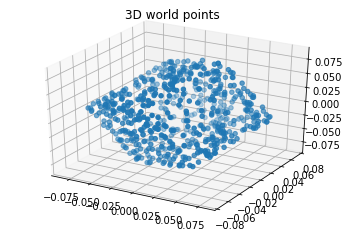

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('3D world points ')
# Perform an SVD decomposition of W
px,py,pz = np.linalg.svd(W)[2][:3]
ax.scatter(px, py, pz)
plt.show()

In [24]:
print ("3D coordinates of the first 10 world points")
print (np.matrix.transpose(np.linalg.svd(W)[2][:3][:, 0:10]))

3D coordinates of the first 10 world points
[[ 0.00577163  0.06460628 -0.02497615]
 [ 0.0005761   0.06885363 -0.03458151]
 [-0.04293585  0.06330479  0.02861711]
 [ 0.04745038  0.04904207 -0.01257547]
 [-0.04210186  0.06789239  0.01175164]
 [ 0.05961964  0.0460518  -0.01438374]
 [ 0.00909167  0.06002049 -0.01229997]
 [ 0.01039489  0.04602065  0.03529275]
 [-0.02589081  0.05702972  0.03337375]
 [ 0.01745598  0.04054264  0.04731859]]
